In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from directories import *
from VAE_models.VAE_model import *
from VAE_models.VAE_model_enhanced import *
from VAE_models.VAE_model_2 import *
from VAE_models.VAE_model_single import *
from training import *
from extras import *
from sklearn.decomposition import PCA

plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"Current working directory: {current_dir}")
print(f"Parent directory: {parent_dir}")

Current working directory: /Users/anastasiiashcherbakova/git_projects/masters_project/genomes/large_dataset_new_loss
Parent directory: /Users/anastasiiashcherbakova/git_projects/masters_project/genomes


# Contents:
#### - [1) Data exploration](#data_exploration)
[1.1) General data exploration](#general_exploration)
[1.2) PCA](#general_exploration)
#### - [2) Data preprocessing](#data_preprocessing)
[2.1) Dataset preprocessing](#dataset_preprocessing)
[2.2) Conversing the dataset into splits and dataloaders](#dataloaders)
#### - [3) Essential genes manipulatioins](#essential)
#### - [4) Training of full dataset (train_full_dataset.py script on the CS account)](#training)
[4.1) Full dataset (base model and enhanced model)](#full_dataset)

<a id='data_exploration'></a>
# 1) Data exploration 

<a id='general_exploration'></a>
## 1.1) General data exploration

In [3]:
essential_genes = pd.read_csv(PAPER_ESSENTIAL_GENES)

In [4]:
large_data = pd.read_csv(TEN_K_DATASET, index_col=[0], header=[0])

In [5]:
# Turning all sample names uppercase
large_data.columns = large_data.columns.str.upper()

In [6]:
large_data

,41004_G02_CONTIGS_PACBIO,50884_F01_CONTIGS_PACBIO,AIAW00000000,AIBY00000000,AIFN00000000,NC_002655,NC_002695,NC_011353,NC_013008,NC_017906,...,ESC_PA2010AA_AS,ESC_PA2013AA_AS,ESC_PA2014AA_AS,ESC_PA2016AA_AS,ESC_PA2019AA_AS,ESC_PA2021AA_AS,ESC_PA2023AA_AS,ESC_PA2315AA_AS,ESC_RA2551AA_AS,ESC_RA2561AA_AS
Strain,,,,,,,,,,,,,,,,,,,,,
Lineage,1,1,1,1,1,1,1,1,1,1,...,51,51,51,51,51,51,51,51,51,51
group_5501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_4456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_6055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
group_2149_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2067_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_2068_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
large_data.sum(axis=1).sort_values()

Strain
group_569           1
group_4401_2        1
group_5102          1
group_5100_2        1
group_5099_3        1
                ...  
hldD             7512
group_4462_2     7512
grxC             7512
diaA             7512
Lineage         55565
Length: 55040, dtype: int64

In [8]:
sum(large_data.sum(axis=0) < 4000)

10

In [9]:
phylogroup_data = pd.read_csv(TEN_K_DATASET_PHYLOGROUPS, index_col=[0], header=[0])

In [10]:
phylogroup_data

,Phylogroup
ID,
ESC_CA4458AA_AS,E
ESC_CA5810AA_AS,E
11657_7#79,B2
ESC_SA7073AA_AS,B1
SRS3528668,Not Determined
...,...
39111_C02,Not determined
ESC_SA2343AA_AS,E
ESC_SA2344AA_AS,E


In [11]:
phylogroup_data.value_counts()

Phylogroup    
E                 3428
B2                2311
Not Determined    1708
B1                1535
D                  345
A                  335
Not determined     232
F                  157
Shigella            67
C                   28
Name: count, dtype: int64

In [12]:
data_without_lineage = large_data.drop(index=['Lineage'])
large_data_t = np.array(data_without_lineage.transpose())

print(f"Full dataset shape: {large_data_t.shape}")


Full dataset shape: (7512, 55039)


In [13]:
threshold_data = []
thresholds = np.linspace(0, 50, num=50)
data_without_lineage = large_data.drop(index=['Lineage'])

for i in thresholds:
    row_sums = data_without_lineage.sum(axis=1)
    threshold_data.append(len(data_without_lineage[row_sums >= i]))


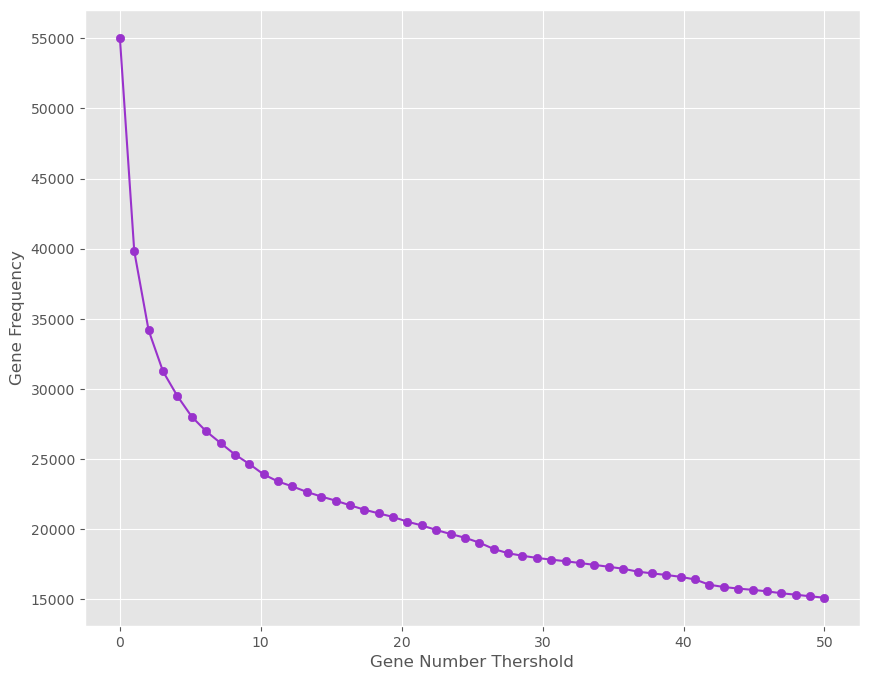

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(thresholds, threshold_data, color='darkorchid')
plt.plot(thresholds, threshold_data, color='darkorchid')
plt.xlabel("Gene Number Thershold")
plt.ylabel("Gene Frequency")
# plt.savefig("figures/gene_frequency_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
gene_count_frequency = data_without_lineage.sum(axis=1)
mean = np.mean(gene_count_frequency)
median = np.median(gene_count_frequency)
min_value = np.min(gene_count_frequency)
max_value = np.max(gene_count_frequency)

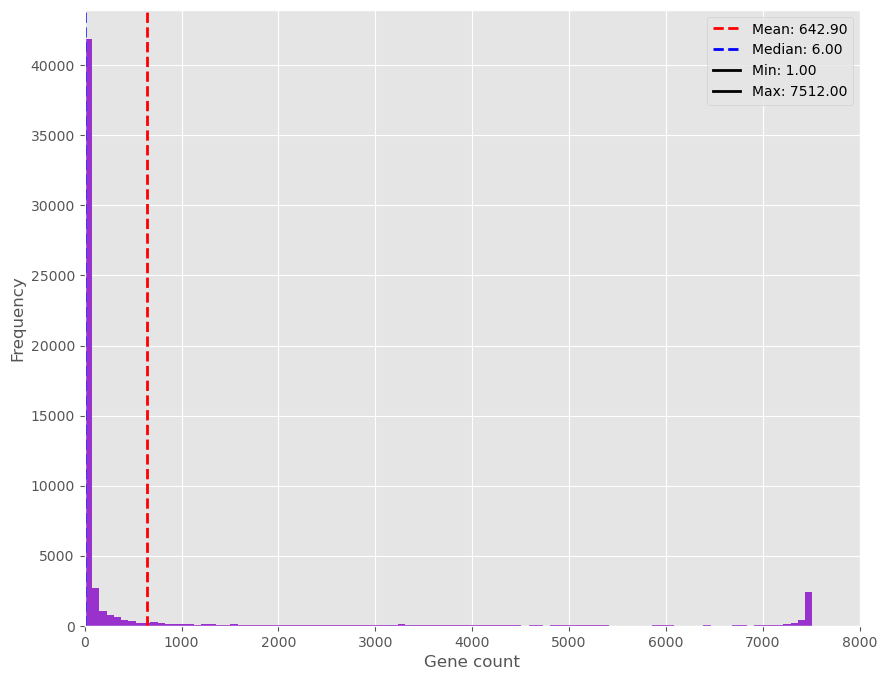

In [16]:
plt.figure(figsize=(10,8))
plt.hist(gene_count_frequency, color='darkorchid', bins=100)
plt.xlim(0, 8000)
plt.xlabel('Gene count')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
# plt.savefig("figures/gene_count_2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [17]:
genome_size_frequency = data_without_lineage.sum(0)
mean = np.mean(genome_size_frequency)
median = np.median(genome_size_frequency)
min_value = np.min(genome_size_frequency)
max_value = np.max(genome_size_frequency)

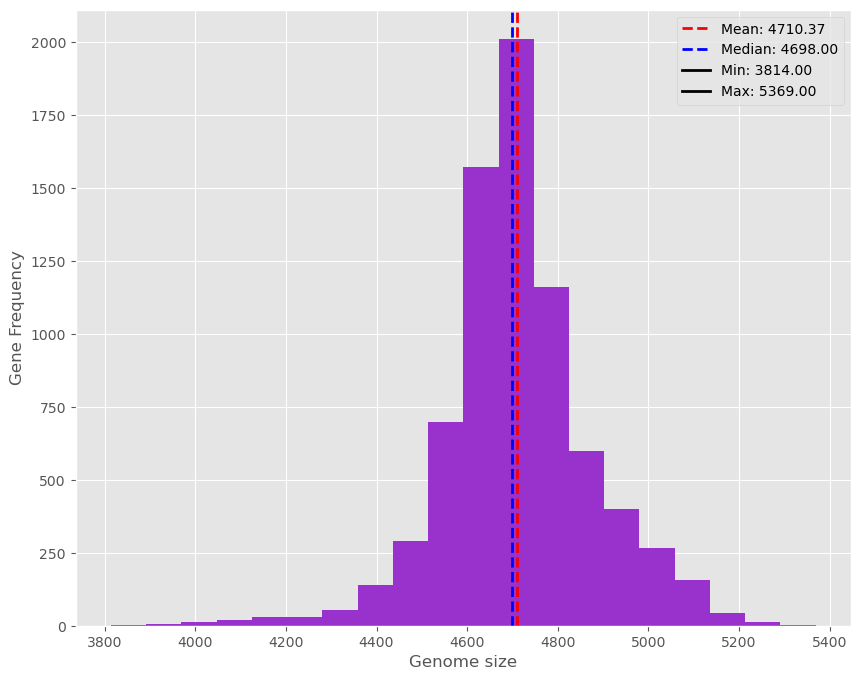

In [18]:
plt.figure(figsize=(10,8))
plt.hist(genome_size_frequency, bins=20, color='darkorchid')
plt.xlabel('Genome size')
plt.ylabel('Gene Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.show()

In [19]:
print(f"Smallest genome: {large_data.sum(0).min()}")

Smallest genome: 3838


## 1.2) PCA

In [20]:
# Inner merge dataset
merged_df = pd.merge(data_without_lineage.transpose(), phylogroup_data, how='inner', left_index=True, right_on='ID')

In [21]:
merged_df

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4,Phylogroup
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,D


In [22]:
print(f"merged dataset shape: {merged_df.shape}")

merged dataset shape: (5953, 55040)


In [23]:
merged_df.iloc[:, :-1]

,group_5501,group_4783,group_4456,group_6055,group_2859,group_3832,group_4223,group_2401,group_1236,group_3245,...,group_1609_5,group_2066_1,mukF_1,group_955_2,group_1382_5,group_2149_7,group_2067_4,group_2068_8,group_2069_3,group_2071_4
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all_genes = merged_df.columns # all genes and phylogroup

In [25]:
merged_df['Phylogroup'].value_counts()

Phylogroup
E           2496
B2          1982
B1           877
D            299
A            111
F            102
Shigella      63
C             23
Name: count, dtype: int64

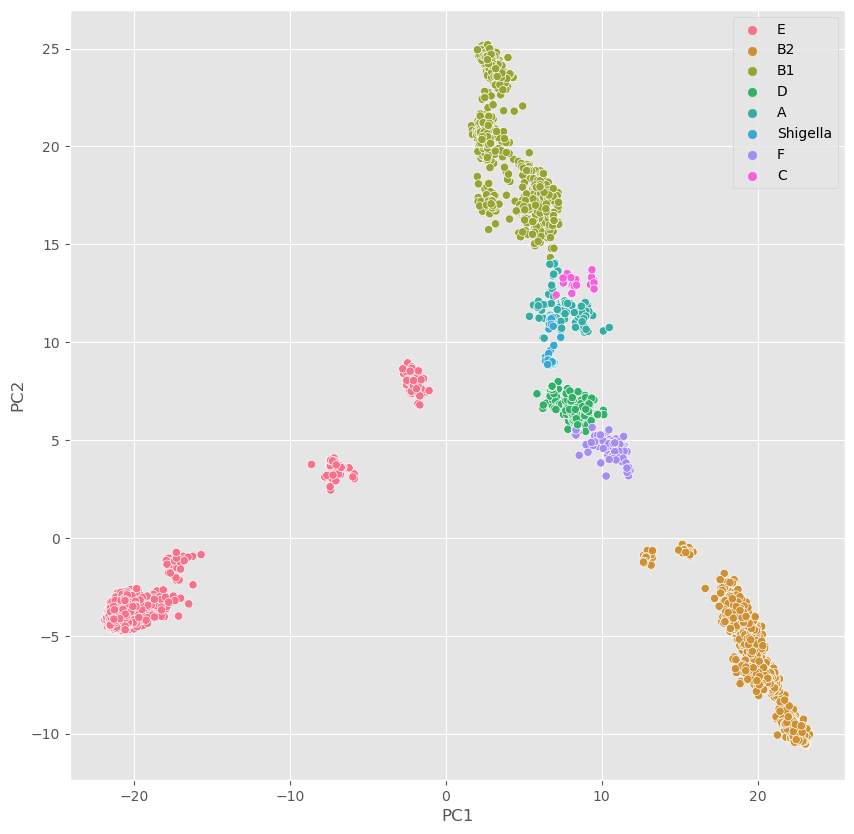

In [26]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(merged_df.iloc[:, :-1])
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = merged_df.Phylogroup.tolist(), data=df_pca)
# plt.savefig("figures/PCA_graph_BD_Phylogroup.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 2) Data preprocessing

## 2.1) Dataset preprocessing 

In [27]:
data_array_t = np.array(merged_df.iloc[:, :-1])
phylogroups_array = np.array(merged_df.iloc[:, -1])

In [28]:
print("Checking dataset shapes")
print(f"Values array: {data_array_t.shape}")
print(f"Phylogroups array: {phylogroups_array.shape}")

Checking dataset shapes
Values array: (5953, 55039)
Phylogroups array: (5953,)


## 2.2) Conversing the dataset into splits and dataloaders

In [29]:
# Convert to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Split into train and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data_tensor, phylogroups_array, test_size=0.3, random_state=12345)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.3333, random_state=12345)
test_phylogroups = test_labels

# Set batch size
batch_size = 32

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# Set laoders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [30]:
print(f"Train data shape {train_data.shape}")
print(f"Test data shape {test_data.shape}")
print(f"Val data shape {val_data.shape}")

Train data shape torch.Size([4167, 55039])
Test data shape torch.Size([596, 55039])
Val data shape torch.Size([1190, 55039])


# 3) Essential genes manipulatioins

In [31]:
# Creating an array of essential genes fromt the paper and flattening it 
essential_genes_array = np.array(essential_genes).flatten()

In [32]:
print(f"Total number of essential genes present in the paper: {len(essential_genes_array)}")

Total number of essential genes present in the paper: 358


In [33]:
# Creating a gene mask for the essential arrays for more optimal counting of the essential arrays present in the samples 
essential_genes_mask = np.isin(all_genes, essential_genes_array)

In [34]:
print(f"Total number of essential genes present in the dataset: {np.sum(essential_genes_mask)}")

Total number of essential genes present in the dataset: 316


In [35]:
# figuring out which genes are not present in the dataset
subset_not_in_essential_genes_mask = essential_genes[~np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [36]:
# figuring out which genes are not present in the dataset
subset_in_essential_genes_mask = essential_genes[np.isin(np.array(essential_genes), np.array(all_genes[essential_genes_mask]))]

In [37]:
absent_genes = np.array(subset_not_in_essential_genes_mask).flatten()

In [38]:
print(f"Number of genes not present in the dataset: {len(absent_genes)}")

Number of genes not present in the dataset: 42


In [39]:
present_genes = np.array(subset_in_essential_genes_mask).flatten()

In [40]:
print(f"Number of genes present in the dataset: {len(present_genes)}") 

Number of genes present in the dataset: 316


In [41]:
# Seeing if the genes split into multiple parts are the essential genes 
matched_columns = []

for gene in absent_genes:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


['msbA_2' 'msbA_1' 'msbA_3' 'fabG_2' 'fabG_1' 'fabG_3' 'fabG_1_1'
 'fabG_2_1' 'fabG_4' 'fabG_4_1' 'fabG_2_2' 'fabG2' 'fabG_2_3' 'lolD_2'
 'lolD_1' 'lolD_3' 'lolD_3_1' 'lolD_4' 'topA_3' 'topA_3_1' 'topA_2'
 'topA_1' 'topA_3_2' 'metG_2' 'metG_2_1' 'metG_2_2' 'fbaA_2' 'fbaA_1'
 'fbaA_3' 'fbaA_3_1' 'fbaA_1_1' 'higA_3' 'higA-1' 'higA1' 'higA1_1'
 'higA_1' 'higA_3_1' 'higA_1_1' 'higA_3_2' 'higA1_2' 'higA_2' 'higA1_3'
 'higA-2' 'higA_2_1' 'lptB_1' 'lptB_1_1' 'ssbA' 'ssb_1' 'ssb_1_1' 'ssb_2'
 'ssb_4' 'ssb_2_1' 'ssb_2_2' 'ssb_1_2' 'ssb_1_3' 'ssb_5' 'ssbA_1' 'lptG_1'
 'lptG_2' 'lptG_3' 'lptG_2_1' 'lptG_1_1' 'dnaC_3' 'dnaC_1' 'dnaC_2'
 'dnaC_1_1' 'dnaC_1_2' 'dnaC_1_3' 'dnaC_1_4' 'dnaC_1_5' 'dnaC_2_1'
 'dnaC_1_6' 'dnaC_2_2']
73


In [42]:
# Manually creating the array of genes which is divided into chunks
divided_genes_prefixes = ['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',  'lptG', 'dnaC'] # 'higA-1', 'higA1','higA-2', 'ssbA' dont count 

In [43]:
not_present = np.array(list(set(absent_genes) - set(divided_genes_prefixes)))

In [44]:
print(f"Genes which are still not present in the dataset after prefix extraction: {not_present}:")
print(f"Total number: {len(not_present)}:")

Genes which are still not present in the dataset after prefix extraction: ['ynbG' 'ymfE' 'cohE' 'ykfM' 'cydX' 'yqeL' 'ydhL' 'dicA' 'trpL' 'yffS'
 'dfp' 'ispU' 'yihA' 'yobI' 'ttcC' 'ydcD' 'yciS' 'racR' 'ydaS' 'ygeF'
 'ymiB' 'yddL' 'yncH' 'ygeN' 'ydaE' 'ycaR' 'cydC' 'pheM' 'yjbS' 'yedN'
 'ygeG']:
Total number: 31:


In [45]:
# Creating a new array of the unique genes presetn in the dataset (single name + divided into chunks genes)
# print("New total number of the genes present in the dataset: ", np.concatenate(present_genes, divided_genes_prefixes))

In [46]:
# Creating a new array of the genes () both sigle name and didived) presetn in the dataset 
combined_array = np.concatenate((present_genes, divided_genes))

In [47]:
len(combined_array)

389

In [48]:
# Creating a new gene mask including the divided essential genes 
essential_genes_mask = np.isin(all_genes, combined_array)

In [49]:
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [50]:
essential_genes_df

,higA_3,topA_3,higA-1,dnaC_3,higA1,ssbA,fbaA_2,holB,metG_2,relB,...,higA-2,lptG_2_1,ssb_1_3,topA_3_2,ssb_5,ssbA_1,metG_2_2,dnaC_2_2,higA_2_1,lptG_1_1
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIBY00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
AIFN00000000,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002655,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
NC_002695,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2023AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ESC_PA2315AA_AS,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
gene_sums = essential_genes_df.sum()
zero_sum_genes = gene_sums[gene_sums == 0].index.tolist()
print(zero_sum_genes)
print(len(zero_sum_genes))

['dnaC_1_3', 'ssb_1_2', 'lptG_2_1']
3


Dataframe of just absent essential genes (including the ones that are split up)

In [52]:
absent_essential_genes_df = pd.DataFrame()

for prefix in absent_genes:
    cols_to_merge = essential_genes_df.filter(regex=f'^{prefix}')
    absent_essential_genes_df[prefix] = (cols_to_merge.sum(axis=1) > 0).astype(int)

In [53]:
absent_essential_genes_df

,ispU,ykfM,cydX,cydC,msbA,ycaR,fabG,lolD,ymfE,cohE,...,ygeN,fbaA,higA,lptB,dfp,yihA,yjbS,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIBY00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
AIFN00000000,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002655,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
NC_002695,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2023AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1
ESC_PA2315AA_AS,0,0,0,0,1,0,1,1,0,0,...,0,1,1,1,0,0,0,1,1,1


Datafarme of the genes that are divided into chunks

In [54]:
intermediate = essential_genes_df.drop(columns=divided_genes)

In [55]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,holA,lptE,leuS,lnt,ybeY,glnS,fldA,hemB,iraM,lpd
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0


Adding the absent essential genes that are present in the dataframe to the overall dataframe of the genes presemt in the datatframe

In [56]:
row_sums = absent_essential_genes_df.sum(axis=0)
columns_to_add = absent_essential_genes_df.columns[row_sums != 0]

In [57]:
columns_to_add

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [58]:
absent_essential_genes_df[columns_to_add]

,msbA,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,
AIAW00000000,1,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,1,1,1,1,1,1,1,1,1,1
NC_002655,1,1,1,1,1,1,1,1,1,1,1
NC_002695,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,1,1,1,1,1,1,1,1,1,1


In [59]:
absent_essential_genes_df[columns_to_add].columns

Index(['msbA', 'fabG', 'lolD', 'topA', 'metG', 'fbaA', 'higA', 'lptB', 'ssb',
       'lptG', 'dnaC'],
      dtype='object')

In [60]:
# Add these selected columns to the original DataFrame
for col in absent_essential_genes_df[columns_to_add].columns:
    intermediate[col] = absent_essential_genes_df[col]

Intermediate dataframe to plot the frequency of the present in the dataframe genes:

In [61]:
intermediate

,holB,relB,coaE,aceF,can,hemL,erpA,dapD,map,rpsB,...,fabG,lolD,topA,metG,fbaA,higA,lptB,ssb,lptG,dnaC
ID,,,,,,,,,,,,,,,,,,,,,
AIAW00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIBY00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AIFN00000000,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002655,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NC_002695,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESC_PA2021AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2023AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ESC_PA2315AA_AS,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [62]:
intermediate.sum(axis=0)

holB    5953
relB      30
coaE    5953
aceF    5953
can     5953
        ... 
higA    5924
lptB    5953
ssb     5941
lptG    5953
dnaC    5949
Length: 327, dtype: int64

In [64]:
np.save('essential_gene_in_ds.npy', intermediate.columns.to_list())

In [ ]:
EG_distribution = intermediate.sum(axis=1)
mean = np.mean(EG_distribution)
median = np.median(EG_distribution)
min_value = np.min(EG_distribution)
max_value = np.max(EG_distribution)

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(EG_distribution, color='darkorchid', bins=20)
plt.xlabel('Essential gene number')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/EG_number.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
EG_distribution = intermediate.sum(axis=1) / intermediate.sum(axis=1).max()
mean = np.mean(EG_distribution)
median = np.median(EG_distribution)
min_value = np.min(EG_distribution)
max_value = np.max(EG_distribution)

In [ ]:
EG_distribution

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(EG_distribution, color='darkorchid', bins=20)
plt.xlabel('Essential gene proportion in the dataset')
plt.ylabel('Frequency')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/EG_number_proportion.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
datatset_EG = list(intermediate.columns)

In [ ]:
from collections import defaultdict

In [ ]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Group gene positions by their prefix
groups_of_gene_positions = defaultdict(list)
for idx, gene in enumerate(all_genes):
    prefix = extract_prefix(gene)
    groups_of_gene_positions[prefix].append(idx)

# Convert defaultdict to a regular dict
groups_of_gene_positions = dict(groups_of_gene_positions)

# Print the dictionary to verify
for prefix, positions in groups_of_gene_positions.items():
    print(f"{prefix}: {positions}")

In [ ]:
# Precompute essential gene positions
essential_gene_positions = {}
for gene in essential_genes_array:
    if gene in groups_of_gene_positions.keys():
        essential_gene_positions[gene] = groups_of_gene_positions[gene]

In [ ]:
essential_gene_positions

In [ ]:
# Initialize a Series to store the abundance of each essential gene
essential_gene_abundance = pd.Series(0, index=essential_genes_array)

# Map positions to actual column names in the DataFrame
column_names = merged_df.columns

# Iterate over precomputed essential gene positions
for gene, positions in essential_gene_positions.items():
    if len(positions) == 1:
        pos = positions[0]
        column_name = column_names[pos]
        essential_gene_abundance[gene] = merged_df[column_name].sum()
    else:
        column_subset = [column_names[pos] for pos in positions]
        essential_gene_abundance[gene] = merged_df[column_subset].sum(axis=1).sum()


In [ ]:
gene_sums = intermediate.sum()
mean = np.mean(gene_sums)
median = np.median(gene_sums)
min_value = np.min(gene_sums)
max_value = np.max(gene_sums)

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist(gene_sums, color='violet')
plt.xlabel('Essential gene Abundance')
plt.ylabel('Frequence')
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')
dummy_min = plt.Line2D([], [], color='black',  linewidth=2, label=f'Min: {min_value:.2f}')
dummy_max = plt.Line2D([], [], color='black', linewidth=2, label=f'Max: {max_value:.2f}')

handles = [plt.Line2D([], [], color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}'),
        plt.Line2D([], [], color='b', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}'),
        dummy_min, dummy_max]
plt.legend(handles=handles)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_frequency.pdf", format="pdf", bbox_inches="tight")

In [ ]:
print(f"Minimal gene abundance: {gene_sums.min()}")

# 4) Training of full dataset (train_full_dataset.py script on the CS account)

## 4.1) Full dataset (base model and enhanced model)

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = '/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/8_final_dataset_new_params/saved_KL_annealing_VAE_BD_100.pt'

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_final_dataset_new_params.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_final_dataset_new_params.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
plot_color = "violet"
figure_name ="/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_final_dataset_new_params.pdf"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

----------

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 1024
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/Desktop/2_bigdataset/2_bigdataset/9_final_dataset_enhanced/saved_KL_annealing_VAE_BD_100.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_9_final_dataset_enhanced.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_9_final_dataset_enhanced.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_9_final_dataset_enhanced.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

## Exploring ways to minimise genome size

just ran a test model with random initial parameters to see how it woudl perform with a new loss (gene abundance) included. L1 regularisation applied to the fetures in the model. one note: the new loss gama and beta params: 
beta_start = 0.1
beta_end = 1.0
gamma_start = 1.0
gamma_end = 0.1

In [ ]:
# Load trained model
input_dim = 55039
hidden_dim = 512
latent_dim = 32
path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_8_new_loss_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

---------

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_8_new_loss_enhanced_model.pt"

model, binary_generated_samples = load_model_enhanced(input_dim, hidden_dim, latent_dim, path_to_model)


In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_8_new_loss_enhanced_model.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_8_new_loss_enhanced_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_8_new_loss_enhanced_model.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

------

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_11_non_linear_annealing_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_11_non_linear_annealing.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_11_non_linear_annealing.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_11_non_linear_annealing.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

_______

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_13_add_genome_size_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_13_add_genome_size.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_13_add_genome_size_model.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_13_add_genome_size.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

______

In [ ]:
# Load trained model 
input_dim = 55039
hidden_dim = 512
latent_dim = 32

path_to_model = "/Users/anastasiiashcherbakova/git_projects/masters_project/models/saved_15_genome_size_and_cyclic_annealing_SCALED_model.pt"

model, binary_generated_samples = load_model(input_dim, hidden_dim, latent_dim, path_to_model)


In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(binary_generated_samples, figure_name, plot_color)

In [ ]:
binary_generated_samples.sum(axis=1).min()

In [ ]:
np.mean(binary_generated_samples.sum(axis=1))

In [ ]:
np.median(binary_generated_samples.sum(axis=1))

In [ ]:
latents = get_latent_variables(model, test_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups

# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/pca_latent_space_visualisation_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
essential_genes_count_per_sample = count_essential_genes(binary_generated_samples, essential_gene_positions)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(binary_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(binary_generated_samples.sum(axis=1), trendline(binary_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# Generate 10 new samples
num_samples = 10000
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution because the latent space follows normal distribution 
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples (binary):\n", binary_generated_samples)
print("\n")
print("Generated samples (sigmoid function output):\n", generated_samples)


In [ ]:
total_ones = np.sum(binary_generated_samples, axis=1)
min_ones_index = np.argmin(total_ones)

latent_distances = np.linalg.norm(generated_samples - generated_samples[min_ones_index], axis=1)

closest_latent_index = np.argmin(latent_distances)

print(f"Closest latent vector (z): {z[closest_latent_index]}")
print(f"Generated sample from closest latent vector:\n {generated_samples[closest_latent_index]}")

In [ ]:
sum(binary_generated_samples[min_ones_index])

In [ ]:
latent_distances

In [ ]:
z_of_interest = z[closest_latent_index] 
z_of_interest_tensor = torch.tensor(z_of_interest).unsqueeze(0)  

noise_std = 0.1

num_additional_samples = 10000  
with torch.no_grad():
    noise = torch.randn(num_additional_samples, latent_dim) * noise_std
    z_samples = z_of_interest_tensor + noise
    additional_generated_samples = model.decode(z_samples).cpu().numpy()


print("Additional generated samples:")
print(additional_generated_samples)

In [ ]:
threshold = 0.5
additional_generated_samples = (additional_generated_samples > threshold).astype(float)

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_sampling_10000_genome_size_distribution_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "dodgerblue"

plot_samples_distribution(additional_generated_samples, figure_name, plot_color)


In [ ]:
essential_gene_positions

In [ ]:
additional_generated_samples.sum(axis=1)

In [ ]:
additional_generated_samples

In [ ]:
np.save('additional_generated_samples.npy', additional_generated_samples)

In [ ]:
essential_genes_count_per_sample = count_essential_genes(additional_generated_samples, essential_gene_positions)

In [ ]:
essential_genes_count_per_sample

In [ ]:
figure_name = "/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additioinal_essential_genes_15_genome_size_and_cyclic_annealing_SCALED.pdf"
plot_color = "violet"

plot_essential_genes_distribution(essential_genes_count_per_sample, figure_name, plot_color)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, color='violet')

coefficients = np.polyfit(additional_generated_samples.sum(axis=1), essential_genes_count_per_sample, 1)
trendline = np.poly1d(coefficients)

plt.plot(additional_generated_samples.sum(axis=1), trendline(additional_generated_samples.sum(axis=1)), color='black', linewidth=2)

plt.xlabel('Essential genes number') 
plt.ylabel('Number of essential gene')

plt.savefig("/Users/anastasiiashcherbakova/git_projects/masters_project/figures/additional_GS_EG_15_genome_size_and_cyclic_annealing_SCALED.pdf", format="pdf", bbox_inches="tight")

---------

In [ ]:
def extract_prefix(gene):
    match = re.match(r"([a-zA-Z0-9]+)", gene)
    if match:
        return match.group(1)
    return gene

# Step 1: Get the top 100 essential gene counts
top_100_values = np.sort(essential_genes_count_per_sample)[-100:][::-1]

# Step 2: Find the sequence indices in the array
sequence_indices = []
for value in top_100_values:
    indices = np.where(essential_genes_count_per_sample == value)[0]
    sequence_indices.extend(indices)

# Ensure we only get the first 100 unique indices in case of duplicates
sequence_indices = sequence_indices[:100]

# Step 3: Get the samples from additional_generated_samples
samples = additional_generated_samples[sequence_indices]

# Step 4: Find what genes they have present
present_genes_lists = []
for sample in samples:
    present_genes = all_genes[:-1][sample == 1]
    present_genes_lists.append(present_genes)

# Step 5: Clean up the gene names and add essential genes
cleaned_genes_lists = []
for genes in present_genes_lists:
    cleaned_gene_names = [extract_prefix(name) for name in genes]
    cleaned_gene_names.extend(datatset_EG) 
    cleaned_genes_lists.append(cleaned_gene_names)

np.save('cleaned_genes_lists.npy', cleaned_genes_lists)

In [ ]:
top_100_values

In [ ]:
saved_values = essential_genes_count_per_sample[-100:][::-1]

In [ ]:
sequence_indecies = []
for i in saved_values:
    sequence_indecies.append(np.where(essential_genes_count_per_sample == i))

In [ ]:
additional_generated_samples[3551]

In [ ]:
present_genes = all_genes[:-1][additional_generated_samples[3551] == 1]

In [ ]:
present_genes

In [ ]:
cleaned_gene_names = [extract_prefix(name) for name in present_genes]
cleaned_gene_names_2 = cleaned_gene_names
unique_gene_names = list(set(cleaned_gene_names))
cleaned_gene_names_2 += datatset_EG
unique_gene_names_2 = list(set(cleaned_gene_names_2))

In [ ]:
len(unique_gene_names)

In [ ]:
len(unique_gene_names_2)

In [ ]:
unique_gene_names_2

In [ ]:
np.save('/Users/anastasiiashcherbakova/git_projects/masters_project/data/unique_gene_names.npy', unique_gene_names_2)

---------

In [ ]:
import pandas as pd
file_path = '/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.txt'

df = pd.read_csv(file_path, delimiter='\t')  

df.to_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv', index=False)

In [ ]:
essential_genes_website = pd.read_csv('/Users/anastasiiashcherbakova/git_projects/masters_project/data/essential_genes_website.csv')

In [ ]:
essential_genes_website_array = np.array(essential_genes_website['Gene Name'])

In [ ]:
essential_genes_website_array

In [ ]:
essential_genes_mask = np.isin(all_genes, essential_genes_website_array)
essential_genes_df = merged_df.loc[:, essential_genes_mask].copy()

In [ ]:
essential_genes_df

In [ ]:
essential_genes_present_array = np.array(essential_genes_df.columns)

In [ ]:
len(essential_genes_present_array)

In [ ]:
genes_missing = list(set(essential_genes_website_array) - set(essential_genes_present_array))

In [ ]:
genes_missing

In [ ]:
len(genes_missing)

In [ ]:
matched_columns = []

for gene in genes_missing:
    pattern = re.compile(f"{gene}")
    matches = [col for col in merged_df.columns if pattern.match(col) and col not in present_genes]
    matched_columns.extend(matches)


divided_genes = np.array(matched_columns)
print(divided_genes)
print(len(divided_genes))


In [ ]:
missing_genes = ['ssb', 'dnaC', 'metG', 'fabG', 'lptB', 'msbA', 'fbaA', 'lolD', 'topA', 'lptG']

----------

# Comparing the two different essential genes arrays

In [ ]:
essential_genes_website_array

In [ ]:
essential_genes_array

In [ ]:
# Find the values that are only in array1
unique_in_array1 = np.setdiff1d(essential_genes_website_array, essential_genes_array)

# Find the values that are only in array2
unique_in_array2 = np.setdiff1d(essential_genes_array, essential_genes_website_array)

print("Values only in website array:", unique_in_array1)
print("Values only in paper array:", unique_in_array2)